# Capstone Project #2 Part 4: Modeling

In this session, we'll build several models and compare the performance

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

from sklearn.metrics import r2_score, mean_squared_log_error, mean_absolute_error
import numpy as np
from tqdm import tqdm
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime
from datetime import timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import pmdarima as pm

In [2]:
import warnings
warnings.filterwarnings("ignore")

## 1. Load data

In [3]:
data = pd.read_csv('preprocessed_data.csv',parse_dates=['timestamp']).set_index('timestamp')

In [4]:
data.head()

,meter_reading,air_temperature,dew_temperature,holiday
timestamp,,,,
2016-01-01,179.822913,-6.229167,-10.283333,1
2016-01-02,175.222208,-5.837500,-9.945833,0
2016-01-03,174.820542,-3.008333,-7.595833,0
2016-01-04,194.201375,-7.229167,-10.004167,0
2016-01-05,203.131417,-4.637500,-8.208333,0


## 2. Transform the data with difference() and plot ACF and PACF

In [5]:
df_daily = data.copy()

In [6]:
diff = df_daily.meter_reading.diff().dropna()

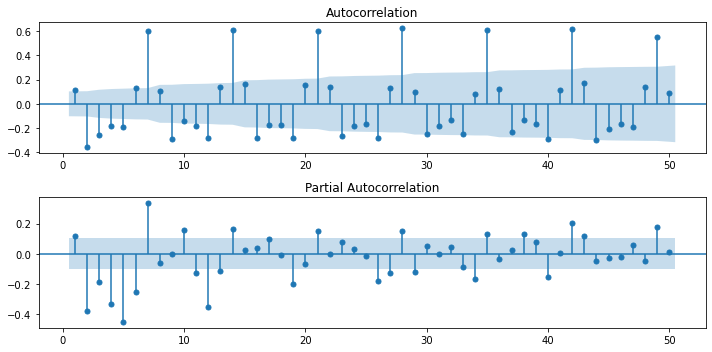

In [7]:
fig, ax = plt.subplots(2,1,figsize=(10,5))
fig = plot_acf(diff, lags=50, zero=False, ax=ax[0])
fig = plot_pacf(diff, lags=50, zero=False, ax=ax[1])
plt.tight_layout()

Both ACF and PACF plots show a seasonal pattern of 7 days

## 3. Basic ARIMA model

Let's first explore a basic ARIMA model without seasonality. We'll split the data in to train set (Jan-Sep) and test set (Oct - Dec)

In [8]:
results = pm.auto_arima(df_daily['2016-1':'2016-9'].meter_reading,
                        seasonal=False,
                        information_criterion='aic',
                        trace=True, # print results whilst training
                        error_action='ignore', # ignore orders that don't work
                        stepwise=True,
                       )

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2019.834, Time=1.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2157.933, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2157.076, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2153.507, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2155.976, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2076.051, Time=1.00 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2061.943, Time=0.76 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2022.364, Time=2.67 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1990.453, Time=2.59 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2075.870, Time=0.52 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2020.483, Time=1.59 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=3.17 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=2072.653, Time=1.18 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=1980.090, Time=2.74 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : 

Let's use the best parameter from auto_arima to fit the model and forecast on the test set

Text(0.5, 1.0, 'Forecast using ARIMA')

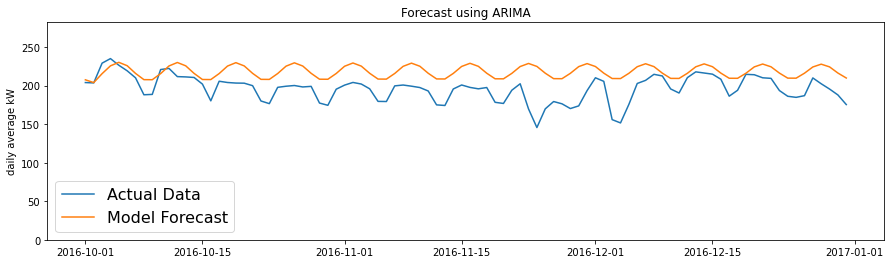

In [9]:
train_data = df_daily['2016-1':'2016-9'].meter_reading
test_data = df_daily['2016-10':].meter_reading

my_order = (2,1,5)

model = SARIMAX(train_data, order=my_order)
model_fit = model.fit()
forecast = model_fit.forecast(test_data.shape[0])
forecast.index = test_data.index

plt.figure(figsize=(15,4))
plt.plot(test_data)
plt.plot(forecast)
plt.ylabel('daily average kW')
plt.legend(('Actual Data', 'Model Forecast'), fontsize=16)
plt.ylim(0,test_data.values.max()*1.2)
plt.title('Forecast using ARIMA')

In [10]:
print('r2: ', r2_score(forecast,test_data))
print('MAE: ',mean_absolute_error(forecast, test_data))

r2:  -10.948862186205648
MAE:  22.729018926240418


The basic arima model is able to capture the weekly repetition, but the shape is a little bit off. Let's see if adding seasonality improves it.

## 4. Basic SARIMAX (no exogenous input)

Run auto_arima again to find the best hyperparameters. But let's add seasonal parameters this time

In [11]:
results = pm.auto_arima(df_daily['2016-1':'2016-9'].meter_reading,
                        seasonal=True,
                        D=1,
                        d=1,
                        m=7,
                        information_criterion='aic',
                        trace=True, # print results whilst training
                        error_action='ignore', # ignore orders that don't work
                        stepwise=True,
                       )

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[7]             : AIC=inf, Time=2.18 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=1987.055, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=1900.429, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.77 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=1984.043, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=1871.308, Time=0.49 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=1.74 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=1.72 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=1887.970, Time=0.43 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=1869.007, Time=0.84 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=1897.981, Time=0.49 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=2.86 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=1.84 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=1867.228, Time=0.63 sec
 ARIMA(3,1,0)(1,1,0)[7]             : AIC=1895.456, Time=0.33 s

Text(0.5, 1.0, 'Forecast using SARIMA')

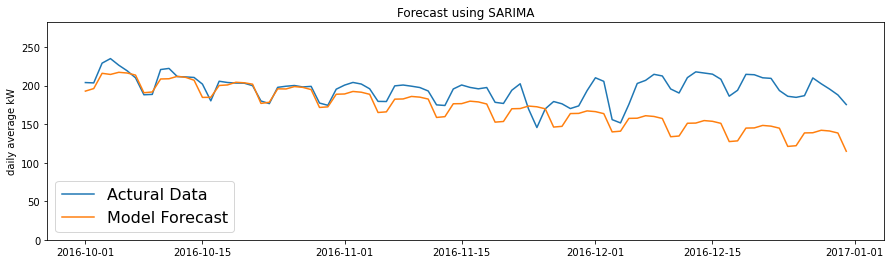

In [12]:
train_data = df_daily['2016-1':'2016-9'].meter_reading
test_data = df_daily['2016-10':].meter_reading

my_order = (5,1,0)
my_seasonal_order = (2,1,0,7)

model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
model_fit = model.fit()
forecast = model_fit.forecast(test_data.shape[0])
forecast.index = test_data.index

plt.figure(figsize=(15,4))
plt.plot(test_data)
plt.plot(forecast)
plt.ylabel('daily average kW')
plt.legend(('Actural Data', 'Model Forecast'), fontsize=16)
plt.ylim(0,test_data.values.max()*1.2)
plt.title('Forecast using SARIMA')

In [13]:
print('r2: ', r2_score(forecast,test_data))
print('MAE: ',mean_absolute_error(forecast, test_data))

r2:  -0.8086177041306042
MAE:  25.469070720049054


The shape of the forecast approximates the actual data much better now. However, the forecast shows a downward trend that seems to be wrong. This is because of the nature of SARIMA model that's based on previous few steps. If the previous data shows a trend, it will just pass on to the future forecast without correcting itself. To improve it, we'll try a rolling forecast.

## 5. Weekly rolling forecast

In this model, we’re not doing a one-time forecast for three months ahead. Instead, we’re doing a rolling 1-week forecast. It means that we start with a one-week forecast. Once the week is past, we add the week to the training set, retrain and update the model and forecast the next week. This gets repeated over and over. 

In [14]:
train_data = df_daily[:'2016-9']
test_data = df_daily['2016-10':'2016-12']
rolling_forecast=pd.DataFrame()
i=0

while i < test_data.shape[0]:
    # print(i)
    n = min(test_data.shape[0]-i,7)
    new_test_data = test_data.iloc[i:(i + n),:]
    model = SARIMAX(train_data.iloc[:,0], 
                    order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()
    forecast = model_fit.forecast(n)
    rolling_forecast = rolling_forecast.append(pd.DataFrame(forecast,columns=['predicted_mean']))
    i = i + 7
    train_data=train_data.append(new_test_data)

Text(0.5, 1.0, 'Rolling Forecast using SARIMA')

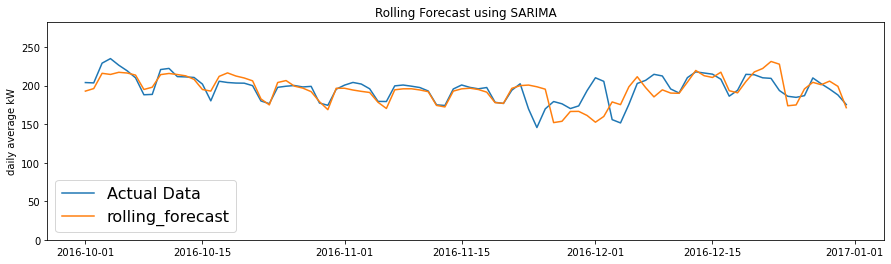

In [15]:
plt.figure(figsize=(15,4))
plt.plot(test_data.meter_reading)
plt.plot(rolling_forecast)
plt.ylabel('daily average kW')
plt.legend(('Actual Data', 'rolling_forecast'), fontsize=16)
plt.ylim(0,test_data.values.max()*1.2)
plt.title('Rolling Forecast using SARIMA')

In [16]:
print('r2: ', r2_score(rolling_forecast[:],test_data.meter_reading))
print('MAE: ',mean_absolute_error(rolling_forecast, test_data.meter_reading))

r2:  0.25534065513208615
MAE:  9.83786532633231


The downward trend from previous model was successfully corrected in rolling forecast. R2 and MAE improve significantly. Let's add holiday feature and see if it further improves the model.

## 6. Rolling forecast + holiday as exogenous input

In [17]:
df_daily_d = df_daily.copy()

In [18]:
df_daily_d.head()

,meter_reading,air_temperature,dew_temperature,holiday
timestamp,,,,
2016-01-01,179.822913,-6.229167,-10.283333,1
2016-01-02,175.222208,-5.837500,-9.945833,0
2016-01-03,174.820542,-3.008333,-7.595833,0
2016-01-04,194.201375,-7.229167,-10.004167,0
2016-01-05,203.131417,-4.637500,-8.208333,0


In [19]:
train_data = df_daily_d[:'2016-9']
test_data = df_daily_d['2016-10':'2016-12']
rolling_forecast=pd.DataFrame()
i=0

while i < test_data.shape[0]:
    # print(i)
    n = min(test_data.shape[0]-i,7)
    new_test_data = test_data.iloc[i:i + n,:]
    model = SARIMAX(train_data.iloc[:,0], 
                    order=my_order, seasonal_order=my_seasonal_order,
                    exog = train_data.iloc[:,-1])
    model_fit = model.fit()
    forecast = model_fit.forecast(n,exog=new_test_data.iloc[:,-1])
    rolling_forecast = rolling_forecast.append(pd.DataFrame(forecast,columns=['predicted_mean']))
    i = i + 7
    train_data=train_data.append(new_test_data)

(0.0, 282.12744999999995)

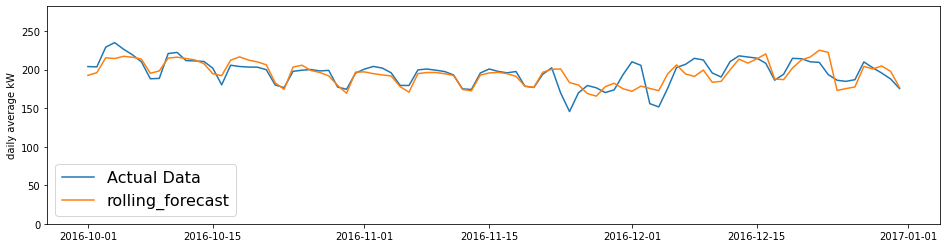

In [20]:
plt.figure(figsize=(16,4))
plt.plot(test_data.iloc[:,0])
plt.plot(rolling_forecast)
plt.ylabel('daily average kW')
plt.legend(('Actual Data', 'rolling_forecast'), fontsize=16)
plt.ylim(0,test_data.values.max()*1.2)

In [21]:
print('r2: ', r2_score(rolling_forecast,test_data.iloc[:,0]))
print('MAE: ',mean_absolute_error(rolling_forecast, test_data.iloc[:,0]))

r2:  0.3951715605556444
MAE:  8.4330775617139


Great! r2 and MAE have improved significantly. Let's finally add the weather feature as exogerous input

## 7. Rolling forecast + holiday + weather as exogenous inputs

In [22]:
df_daily_d_w = df_daily_d.copy()

In [23]:
df_daily_d_w.head()

,meter_reading,air_temperature,dew_temperature,holiday
timestamp,,,,
2016-01-01,179.822913,-6.229167,-10.283333,1
2016-01-02,175.222208,-5.837500,-9.945833,0
2016-01-03,174.820542,-3.008333,-7.595833,0
2016-01-04,194.201375,-7.229167,-10.004167,0
2016-01-05,203.131417,-4.637500,-8.208333,0


In EDA session, it's found that when air temperature goes above 12F and dew point goes above 8F, they start to impact electricity consumption. So let's adjust the temperature a little bit accordingly.

In [24]:
df_daily_d_w['temp'] = df_daily_d_w['air_temperature'].apply(lambda x: 12 if x <12 else x)
df_daily_d_w['dewpoint'] = df_daily_d_w['dew_temperature'].apply(lambda x: 8 if x <8 else x)
df_daily_d_w.drop(['air_temperature','dew_temperature'], axis=1,inplace=True)

In [25]:
train_data = df_daily_d_w[:'2016-9']
test_data = df_daily_d_w['2016-10':]
rolling_forecast=pd.DataFrame()
i=0

while i < test_data.shape[0]:
    # print(i)
    n = min(test_data.shape[0]-i,7)
    new_test_data = test_data.iloc[i:i + n,:]
    model = SARIMAX(train_data.iloc[:,0], 
                    order=my_order, seasonal_order=my_seasonal_order,
                    exog = train_data.iloc[:,1:])
    model_fit = model.fit()
    forecast = model_fit.forecast(n,exog=new_test_data.iloc[:,1:])
    rolling_forecast = rolling_forecast.append(pd.DataFrame(forecast,columns=['predicted_mean']))
    i = i + 7
    train_data=train_data.append(new_test_data)

Text(0.5, 1.0, 'Rolling Forecast using SARIMAX')

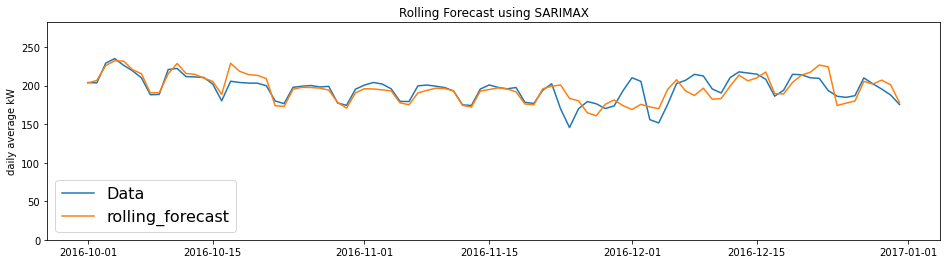

In [26]:
plt.figure(figsize=(16,4))
plt.plot(test_data.iloc[:,0])
plt.plot(rolling_forecast)
plt.ylabel('daily average kW')
plt.legend(('Data', 'rolling_forecast'), fontsize=16)
plt.ylim(0,test_data.values.max()*1.2)
plt.title('Rolling Forecast using SARIMAX')

In [27]:
print('r2: ', r2_score(rolling_forecast,test_data.iloc[:,0]))
print('MAE: ',mean_absolute_error(rolling_forecast, test_data.iloc[:,0]))

r2:  0.5201703045224237
MAE:  8.230118101595718


## 8. Random Forest

In comparison, let's try a random forest model and see the results.

In [28]:
df_daily_d_w.head()

,meter_reading,holiday,temp,dewpoint
timestamp,,,,
2016-01-01,179.822913,1,12.0,8.0
2016-01-02,175.222208,0,12.0,8.0
2016-01-03,174.820542,0,12.0,8.0
2016-01-04,194.201375,0,12.0,8.0
2016-01-05,203.131417,0,12.0,8.0


In [29]:
# Create week of day features

df_rf = df_daily_d_w.copy()
df_rf.loc[:,'weekday']=df_rf.index.weekday + 1
df_rf = pd.get_dummies(df_rf,columns=['weekday'],drop_first=True)
X = df_rf.drop(['meter_reading'],axis=1)
y = df_rf.meter_reading

In [30]:
X.head()

,holiday,temp,dewpoint,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
timestamp,,,,,,,,,
2016-01-01,1,12.0,8.0,0,0,0,1,0,0
2016-01-02,0,12.0,8.0,0,0,0,0,1,0
2016-01-03,0,12.0,8.0,0,0,0,0,0,1
2016-01-04,0,12.0,8.0,0,0,0,0,0,0
2016-01-05,0,12.0,8.0,1,0,0,0,0,0


In [31]:
X_train = X[:'2016-9']
X_test = X['2016-10':]
y_train = y[:'2016-9']
y_test = y['2016-10':]

In [32]:
# create grid search to evaluate different numbers of trees
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {'n_estimators': n_est} # n_est = [10,12,16,20,...] try different number of trees
grid_cv = GridSearchCV(RandomForestRegressor(), param_grid=grid_params, cv=2, n_jobs=-1)

In [33]:
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'n_estimators': [10, 12, 16, 20, 26, 33, 42, 54, 69,
                                          88, 112, 143, 183, 233, 297, 379, 483,
                                          615, 784, 1000]})

In [34]:
grid_cv.best_params_

{'n_estimators': 26}

In [35]:
pred = grid_cv.predict(X_test)
print('RF-r2: ', r2_score(y_test, pred))
print('MAE: ',mean_absolute_error(y_test, pred))
comparison = pd.DataFrame(y_test)
comparison.loc[:,'pred']=pred

RF-r2:  0.391485763303129
MAE:  9.88085236656875


Text(0.5, 1.0, 'Forecast using Random Forest')

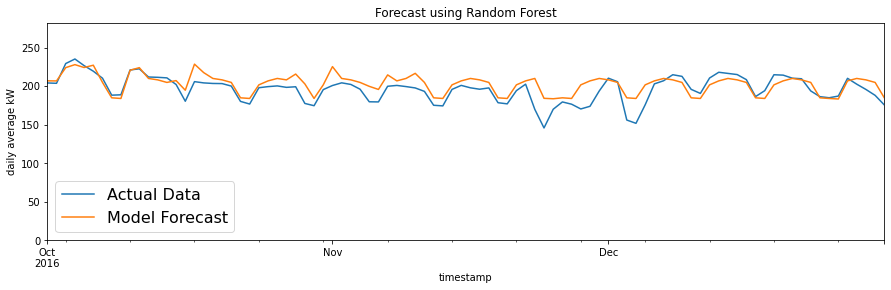

In [36]:
comparison.plot(figsize=(15,4))
plt.ylabel('daily average kW')
plt.legend(('Actual Data', 'Model Forecast'), fontsize=16)
plt.ylim(0,y_test.values.max()*1.2)
plt.title('Forecast using Random Forest')

## 9. Summary

1. In this project, ARIMA and SARIMAX don't seem to perform well enough for a one-time long term forecast. The models tend to pick up a trend from prior steps and assume the trend will continue in the future. As a result, the forecast is very sensitive to the last few steps in the train data set. 
2. Time series models perform much better forecast if done in a rolling manner, which is more focused on short term forecast.
3. Adding exogenous features, such as holiday schedule, weather data can improve the accuracy of time series models.
4. Random forecast can be an alternative solution to consider if a one-time long term type forecast is needed. 